## Naive Bayes Analysis

In [1]:
# Import Libraries
import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
import numpy as np
from pandas.api.types import CategoricalDtype
import re
# Data is stored in external directory
path = "../data/cleaned_data/grad_cafe_admissions_updated.csv"
fields = []
rows = []
 
# Import data
# reading csv file
with open(path, 'r') as csvfile:
    # creating a csv reader object
    csvreader = csv.reader(csvfile)
     
    # extracting field names through first row
    fields = next(csvreader)
 
    # extracting each data row one by one
    for row in csvreader:
        rows.append(row)
# Convert into dataframe
df = pd.DataFrame (rows, columns = fields)

### 1. Data analysis

In [2]:
nan_count=list()
for field in fields:
    nan_count.append(df[df[field]=='NA'][field].count())

### 1.A. Identifying missing labels per feature

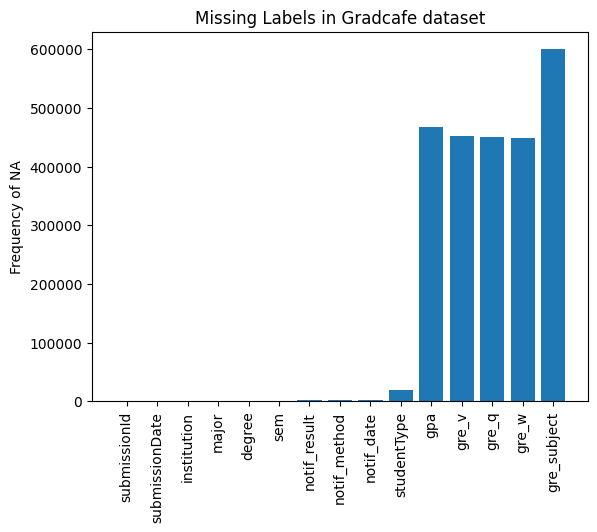

In [3]:
plt.bar(list(range(len(nan_count))), nan_count)
plt.xticks(list(range(len(nan_count))), fields, rotation=90)
plt.ylabel('Frequency of NA')
plt.title('Missing Labels in Gradcafe dataset')
plt.show()

In [4]:
# Cleaning dataset
def remove_non_latin(string):
    string = re.sub(r'[^\x41-\x5a|\x61-\x7a]',r'', string)
    string = re.findall('[A-Z][^A-Z]*', string)
    
    return ' '.join(string)
for field in ["institution", "major", "degree", "sem"]:
    df[field] = df[field].apply(remove_non_latin)
df.head()

,submissionId,submissionDate,institution,major,degree,sem,notif_result,notif_method,notif_date,studentType,gpa,gre_v,gre_q,gre_w,gre_subject
0,1,2006-02-08,Pennsylvania State University P S U,Political Science,Ph D,F,Rejected,Postal Service,2006-02-16,O,NA,NA,NA,NA,NA
1,4,2006-02-10,Ohio State University O S U,Social Work,Masters,F,Accepted,Phone,2005-11-16,O,NA,NA,NA,NA,NA
2,9,2006-02-10,University Of Colorado Boulder,Clinical Psychology,N A,F,Interview,Phone,2006-01-26,O,NA,NA,NA,NA,NA
3,12,2006-02-10,Purdue University,Nuclear Engineering,Ph D,F,Accepted,Postal Service,2006-01-30,O,NA,NA,NA,NA,NA
4,17,2006-02-10,Indiana University Bloomington,Information Science Masters,N A,F,Accepted,Postal Service,2006-01-11,O,NA,NA,NA,NA,NA


In [5]:
# Calculating statistics for every field
field_mean = dict()
field_median = dict()
field_max = [4, 170, 170, 4, 990]
field_min = [0, 130, 130, 0, 220]
print("Statistics of main labels in gradcafe dataset")
for i, field in enumerate(fields[-5:]):
    x = df[df[field].str.isnumeric()][[field]]
    x.replace([np.inf, -np.inf], np.nan, inplace=True)
    x = x[(x.to_numpy().astype(float)<=field_max[i]) & \
          (x.to_numpy().astype(float)>=field_min[i])]
    field_mean[field] = x.to_numpy().astype(float).mean()
    field_median[field] = x.median().iat[0]
    print("Label: {0}:".format(field))
    print("Median: {0}".format(field_median[field]))
    print("Mean: {0} \n".format(field_mean[field]))

Statistics of main labels in gradcafe dataset
Label: gpa:
Median: 4.0
Mean: 3.8449064152021717 

Label: gre_v:
Median: 160.0
Mean: 159.2575876351383 

Label: gre_q:
Median: 162.0
Mean: 160.664937596825 

Label: gre_w:
Median: 4.0
Mean: 3.181466676357293 

Label: gre_subject:
Median: 800.0
Mean: 792.458537208016 



### 2.C Training Using Gaussian Naive Bayes

In [6]:
# One-hot vector
def get_ohv(Z_original, Z_, f):
    Z_temp = np.array(Z_original)
    Z_ohv = np.zeros((Z_temp[:,f].size, Z_[:,f].max()+1))
    
    Z_ohv[np.arange(Z_temp[:,f].size), Z_temp[:,f]]=1
    return Z_ohv

#### A. Training for Data with no-missing labels

In [7]:
# Remove rows with NAN object in any rows
df_new = df
df_imputed = df_new[(df_new["gpa"].str.isnumeric()==True) & \
           (df_new["gre_v"].str.isnumeric()==True) & \
           (df_new["gre_q"].str.isnumeric()==True) & \
           (df_new["gre_w"].str.isnumeric()==True) & \
           (df_new["gre_subject"].str.isnumeric()==True) ]
# Remove Field values beyond permissble limits
# Mean is used to fill empty cells
for i, field in enumerate(fields[-5:]):
    df_imputed.loc[(df_imputed[field].str.isnumeric()==False) & \
                   (df_imputed[field].to_numpy().astype(float)<=field_max[i]) & \
                   (df_imputed[field].to_numpy().astype(float)>=field_min[i]), field]=field_mean[field]
df_imputed.head()

/var/folders/bd/y38b3rb96b90p6bnpfms_2ww0000gn/T/ipykernel_8140/1913669544.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imputed.loc[(df_imputed[field].str.isnumeric()==False) & \


,submissionId,submissionDate,institution,major,degree,sem,notif_result,notif_method,notif_date,studentType,gpa,gre_v,gre_q,gre_w,gre_subject
54843,64519,2010-01-12,Stanford University,Psychology,Ph D,F,Interview,E-mail,2010-01-12,A,4,164,166,5,780
55047,64749,2010-01-15,University Of Michigan Ann Arbor,Social Psychology,Ph D,F,Rejected,E-mail,2010-01-15,A,4,164,166,5,780
55336,65057,2010-01-21,Florida State University,Counseling Psychology,Ph D,F,Interview,E-mail,2009-11-23,U,4,159,155,4,810
55337,65058,2010-01-21,University Of Iowa,Counseling Psychology,Ph D,F,Interview,E-mail,2010-01-07,U,4,159,155,4,810
55447,65187,2010-01-22,Michigan State University,Social Psychology,Ph D,F,Interview,E-mail,2010-01-19,A,4,164,166,5,780


In [8]:
# Verify dataset. For this dataset only two output labels are considered "Accepted" and "Rejceted"
cats = ["Accepted", "Rejected"]
cat_type = CategoricalDtype(categories=cats, ordered=False)
X = df_imputed[fields[-5:]].to_numpy()
Y_cat = df_imputed[fields[-9]].astype(cat_type)
Y = Y_cat.cat.codes.to_numpy() + 1
Y_labels = Y_cat.cat.categories
Z = list()
Z_label = list()
for field in ["institution", "major"]:
    Z_cat = df_imputed[field].astype(CategoricalDtype())
    Z.append(Z_cat.cat.codes.to_numpy())
    Z_label.append(Z_cat.cat.categories)
Z = np.array(Z).T
X.shape, Y.shape, Y_labels, Z.shape

((1342, 5),
 (1342,),
 Index(['Accepted', 'Rejected'], dtype='object'),
 (1342, 2))

In [9]:
# K-fold cross Validation
k = 10
# prepare cross validation
kf = KFold(n_splits=k)
# enumerate splits
Score = list()
for i, (train_index, test_index) in enumerate(kf.split(X)):
    clf = GaussianNB()
    X_train = X[train_index][:,:-2]
    for k in range(len(Z_label)):
        X_train = np.hstack((X_train, get_ohv(Z[train_index],Z, k)))
    clf.fit(X_train, Y[train_index])
    X_test = X[test_index][:,:-2]
    for k in range(len(Z_label)):
        X_test = np.hstack((X_test, get_ohv(Z[test_index],Z, k)))
    Score.append(clf.score(X_test, Y[test_index]))
print("Training using Gaussian Naive Bayes(full input vector)")
print(u"Accuracy after 10-fold cross-validation {0:.3f} \u00B1 {1:.3f}%".format(100*np.mean(Score), 100*np.std(Score)))
print("Max accuracy {0:.3f}%".format(np.max(Score)*100))

Training using Gaussian Naive Bayes(full input vector)
Accuracy after 10-fold cross-validation 28.831 ± 5.159%
Max accuracy 35.821%


In [11]:
# Store OHV
f=1
Z_original = np.arange(Z[:,f].max())
Z_ohv = np.zeros((Z_original.size, Z[:,f].max()))
Z_ohv[np.arange(Z_original.size), Z_original]=1# Z_original
OHV_dict = dict()
for label, z_ohv in zip(Z_label[f], Z_ohv):
    OHV_dict[label] = z_ohv
# OHV_dict

**Deprecating following code section B. and C.**

#### B. Using feature Mean for missing labels

In [12]:
# Remove NAN objects 
df_new = df
df_imputed = df_new[(df_new["gpa"].str.isnumeric()==True) | \
           (df_new["gre_v"].str.isnumeric()==True) | \
           (df_new["gre_q"].str.isnumeric()==True) | \
           (df_new["gre_w"].str.isnumeric()==True) | \
           (df_new["gre_subject"].str.isnumeric()==True) ]
# Remove Field values beyond permissble limits
# Mean is used to fill empty cells
for i, field in enumerate(fields[-5:]):
    df_imputed.loc[(df_imputed[field].str.isnumeric()==False), field] = field_mean[field] 
    df_imputed.loc[(df_imputed[field].to_numpy().astype(float)>=field_max[i]) | \
                   (df_imputed[field].to_numpy().astype(float)<=field_min[i]), field]=field_mean[field]
df_imputed.head()

C:\Users\solit\AppData\Local\Temp\ipykernel_13112\604907295.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imputed.loc[(df_imputed[field].str.isnumeric()==False), field] = field_mean[field]
C:\Users\solit\AppData\Local\Temp\ipykernel_13112\604907295.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imputed.loc[(df_imputed[field].to_numpy().astype(float)>=field_max[i]) | \


,submissionId,submissionDate,institution,major,degree,sem,notif_result,notif_method,notif_date,studentType,gpa,gre_v,gre_q,gre_w,gre_subject
54827,64500,2010-01-12,University Of California San Francisco U C S F,Neuroscience,Ph D,F,Interview,Phone,2010-01-12,A,3.844906,162,163,3.181467,792.458537
54828,64501,2010-01-12,University Of California San Francisco U C S F,Neuroscience,Ph D,F,Interview,Phone,2010-01-12,A,3.844906,160,166,3.181467,792.458537
54830,64506,2010-01-12,University College London,International Public Policy,Masters,F,Accepted,E-mail,2009-11-26,A,3.844906,154,155,3.181467,792.458537
54831,64507,2010-01-12,London School Of Economics L S E,Master Of Public Administration M P A,Masters,F,Accepted,E-mail,2010-01-11,A,3.844906,154,155,3.181467,792.458537
54832,64508,2010-01-12,Carnegie Mellon,Biological Sciences Neuroscience,Ph D,F,Interview,E-mail,2010-01-12,A,3.844906,165,166,3.181467,792.458537


In [22]:
# Verify dataset. For this dataset only two output labels are considered "Accepted" and "Rejceted"
cats = ["Accepted", "Rejected"]
cat_type = CategoricalDtype(categories=cats, ordered=False)
X = df_imputed[fields[-5:]].to_numpy()
Y_cat = df_imputed[fields[-9]].astype(cat_type)
Y = Y_cat.cat.codes.to_numpy() + 1
Y_labels = Y_cat.cat.categories
Z = list()
Z_label = list()
for field in ["institution", "major"]:
    Z_cat = df_imputed[field].astype(CategoricalDtype())
    Z.append(Z_cat.cat.codes.to_numpy())
    Z_label.append(Z_cat.cat.categories)
Z = np.array(Z).T
X.shape, Y.shape, Y_labels, Z.shape

((1342, 5),
 (1342,),
 Index(['Accepted', 'Rejected'], dtype='object'),
 (1342, 2))

In [ ]:
# K-fold cross Validation
k = 10
# prepare cross validation
kf = KFold(n_splits=k)
# enumerate splits
Score = list()
for i, (train_index, test_index) in enumerate(kf.split(X)):
    clf = GaussianNB()
    X_train = X[train_index][:,:-2]
    for k in range(len(Z_label)):
        X_train = np.hstack((X_train, get_ohv(Z[train_index],Z, k)))
    clf.fit(X_train, Y[train_index])
    X_test = X[test_index][:,:-2]
    for k in range(len(Z_label)):
        X_test = np.hstack((X_test, get_ohv(Z[test_index],Z, k)))
print("Training using Gaussian Naive Bayes(full input vector)")
print(u"Accuracy after 10-fold cross-validation {0:.3f} \u00B1 {1:.3f}%".format(100*np.mean(Score), 100*np.std(Score)))
print("Max accuracy {0:.3f}%".format(np.max(Score)*100))

#### C. Using feature Median for missing labels

In [33]:
# Remove NAN objects 
df_new = df
df_imputed = df_new[(df_new["gpa"].str.isnumeric()==True) | \
           (df_new["gre_v"].str.isnumeric()==True) | \
           (df_new["gre_q"].str.isnumeric()==True) | \
           (df_new["gre_w"].str.isnumeric()==True) | \
           (df_new["gre_subject"].str.isnumeric()==True) ]
# Remove Field values beyond permissble limits
# Mean is used to fill empty cells
for i, field in enumerate(fields[-5:]):
    df_imputed.loc[(df_imputed[field].str.isnumeric()==False), field] = field_median[field] 
    df_imputed.loc[(df_imputed[field].to_numpy().astype(float)>=field_max[i]) | \
                   (df_imputed[field].to_numpy().astype(float)<=field_min[i]), field]=field_median[field]
df_imputed.head()

/var/folders/bd/y38b3rb96b90p6bnpfms_2ww0000gn/T/ipykernel_2493/4270392296.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imputed.loc[(df_imputed[field].str.isnumeric()==False), field] = field_median[field]
/var/folders/bd/y38b3rb96b90p6bnpfms_2ww0000gn/T/ipykernel_2493/4270392296.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imputed.loc[(df_imputed[field].to_numpy().astype(float)>=field_max[i]) | \


,submissionId,submissionDate,institution,major,degree,sem,notif_result,notif_method,notif_date,studentType,gpa,gre_v,gre_q,gre_w,gre_subject
54827,64500,2010-01-12,University Of California San Francisco U C S F,Neuroscience,Ph D,F,Interview,Phone,2010-01-12,A,4.0,162,163,4.0,800.0
54828,64501,2010-01-12,University Of California San Francisco U C S F,Neuroscience,Ph D,F,Interview,Phone,2010-01-12,A,4.0,160,166,4.0,800.0
54830,64506,2010-01-12,University College London,International Public Policy,Masters,F,Accepted,E-mail,2009-11-26,A,4.0,154,155,4.0,800.0
54831,64507,2010-01-12,London School Of Economics L S E,Master Of Public Administration M P A,Masters,F,Accepted,E-mail,2010-01-11,A,4.0,154,155,4.0,800.0
54832,64508,2010-01-12,Carnegie Mellon,Biological Sciences Neuroscience,Ph D,F,Interview,E-mail,2010-01-12,A,4.0,165,166,4.0,800.0


In [34]:
# Verify dataset. For this dataset only two output labels are considered "Accepted" and "Rejceted"
cats = ["Accepted", "Rejected"]
cat_type = CategoricalDtype(categories=cats, ordered=False)
X = df_imputed[fields[-5:]].to_numpy()
Y_cat = df_imputed[fields[-9]].astype(cat_type)
Y = Y_cat.cat.codes.to_numpy() + 1
Y_labels = Y_cat.cat.categories
Z = list()
Z_label = list()
for field in ["institution", "major", "degree", "sem"]:
    Z_cat = df_imputed[field].astype(CategoricalDtype())
    Z.append(Z_cat.cat.codes.to_numpy())
    Z_label.append(Z_cat.cat.categories)
Z = np.array(Z).T
X.shape, Y.shape, Y_labels, Z.shape

((175987, 5),
 (175987,),
 Index(['Accepted', 'Rejected'], dtype='object'),
 (175987, 4))

In [35]:
# K-fold cross Validation
k = 10
# prepare cross validation
kf = KFold(n_splits=k)
# enumerate splits
Score = list()
for i, (train_index, test_index) in enumerate(kf.split(X)):
    clf = GaussianNB()
    clf.fit(np.hstack((X[train_index], Z[train_index])), Y[train_index])
    Score.append(clf.score(np.hstack((X[test_index], Z[test_index])), Y[test_index]))
print("Training using Gaussian Naive Bayes(full input vector)")
print(u"Accuracy after 10-fold cross-validation {0:.3f} \u00B1 {1:.3f}%".format(100*np.mean(Score), 100*np.std(Score)))
print("Max accuracy {0:.3f}%".format(np.max(Score)*100))

Training using Gaussian Naive Bayes(full input vector)
Accuracy after 10-fold cross-validation 50.352 ± 0.666%
Max accuracy 51.702%


**Conclusion**: It is apparent from the results that the Naive Bayes is not very efficient on the given dataset. Even with no missing labels maximum achieved accuracy is **60%**</br>
**This means two of the following things:**</br>
[1]. **Classifier is weak**</br>
[2]. **There are unrealiable samples in the dataset**</br>

In the following experiments we will try to single out samples based on a few variables ie. University, Degree Profram, admission year. We will use the influential labels in our Bayes Classifier.

**1. Per-university Classifier**

Text(0.5, 1.0, 'Histogram for number of samples for University')

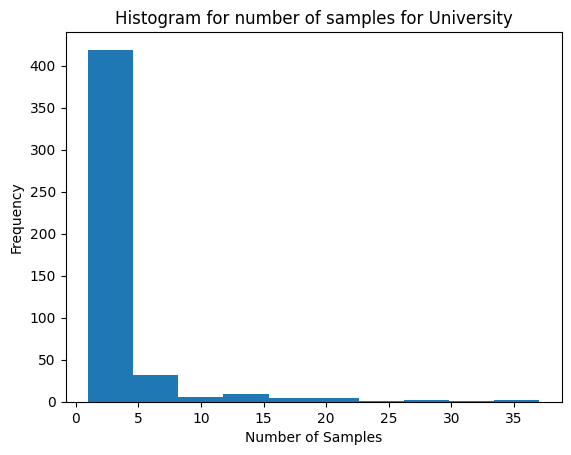

In [12]:
# Per-university samples
f = 0
samples = list()
for i, uni in enumerate(Z_label[f]):
    idx = np.where(Z[:,f] == i)[0]
    samples.append(len(idx))
plt.hist(samples)
plt.xlabel('Number of Samples')
plt.ylabel('Frequency')
plt.title('Histogram for number of samples for University')

**From the above image it is clear that per-univeristy sample distribution is disproportionate.**

In [13]:
Results = list()
# Field number
f=0
# min number of samples
NB_Classifier = dict()
min_samples = 10
for i, field in enumerate(Z_label[f]):
    idx = np.where(Z[:,f] == i)[0]
    if len(idx)>min_samples:
        result = dict()
        accuracy = list()
        y_ = list()
        for i, (train_index, test_index) in enumerate(kf.split(idx)):
            clf = GaussianNB()
            X_train = X[idx[train_index]][:,:-2]

            for k in range(len(Z_label)):
                if k != f:
                    X_train = np.hstack((X_train, get_ohv(Z[idx[train_index]],Z, k)))
#             clf.fit(np.hstack((X[idx[train_index]][:,:-2], Z[idx[train_index]][:,:f], Z[idx[train_index]][:, f+1:])), \
#                     Y[idx[train_index]])
            NB_Classifier[field] = clf.fit(X_train, Y[idx[train_index]])
            X_test = X[idx[test_index]][:,:-2]
            for k in range(len(Z_label)):
                if k != f:
                    X_test = np.hstack((X_test, get_ohv(Z[idx[test_index]],Z,k)))
#             accuracy.append(clf.score(np.hstack((X[idx[test_index]][:,:-2], \
#                                                  Z[idx[test_index]][:,:f], \
#                                                 Z[idx[test_index]][:, f+1:])), Y[idx[test_index]]))
            accuracy.append(clf.score(X_test, Y[idx[test_index]]))
            y_.append(np.sum(Y[idx[train_index]]==1)/len(train_index))
        result['field'] = field
        result['Mean Accuracy'] = np.mean(accuracy)*100
        result['Max Accuracy'] = np.max(accuracy)*100
        result['Std Dev'] = np.std(accuracy)*100
        result['Number of samples'] = len(idx)
        result['verbose']= "{0}: \n Number of samples: {1} Mean Accuracy: {2:.3f}% Std dev: {3:.3f}% Max Accuracy {4:.3f}% \n".\
              format(field, len(idx), np.mean(accuracy)*100, np.std(accuracy)*100, np.max(accuracy)*100)
        result['% Lable'] = np.mean(y_)
        Results.append(result)
Results = sorted(Results, key=lambda x : x['Mean Accuracy'], reverse=True)
print('Top university samples with mean accuracy')
for i in range(len(Results)):
    print(Results[i]['verbose'])
    print("Accepted labels: {0:.2f}%\n".format(100*Results[i]['% Lable']))

Top university samples with mean accuracy
U C L A: 
 Number of samples: 16 Mean Accuracy: 90.000% Std dev: 20.000% Max Accuracy 100.000% 

Accepted labels: 31.24%

Brown University: 
 Number of samples: 11 Mean Accuracy: 85.000% Std dev: 32.016% Max Accuracy 100.000% 

Accepted labels: 54.56%

Cornell: 
 Number of samples: 17 Mean Accuracy: 75.000% Std dev: 33.541% Max Accuracy 100.000% 

Accepted labels: 47.08%

U C Berkeley: 
 Number of samples: 27 Mean Accuracy: 68.333% Std dev: 22.913% Max Accuracy 100.000% 

Accepted labels: 62.95%

University Of Chicago: 
 Number of samples: 31 Mean Accuracy: 67.500% Std dev: 25.941% Max Accuracy 100.000% 

Accepted labels: 45.15%

University Of Washington: 
 Number of samples: 19 Mean Accuracy: 65.000% Std dev: 32.016% Max Accuracy 100.000% 

Accepted labels: 47.35%

Columbia University: 
 Number of samples: 12 Mean Accuracy: 60.000% Std dev: 48.990% Max Accuracy 100.000% 

Accepted labels: 41.55%

University Of Michigan Ann Arbor: 
 Number of s

In [14]:
# Dump the model
import pickle
filename = './NB_classifier.npy'
pickle.dump(NB_Classifier, open(filename, 'wb'))

In [15]:
# Load model
filename = './NB_classifier.npy'
loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
loaded_model

{'Brown University': GaussianNB(),
 'Columbia University': GaussianNB(),
 'Cornell': GaussianNB(),
 'Cornell University': GaussianNB(),
 'Duke University': GaussianNB(),
 'Harvard': GaussianNB(),
 'Harvard University': GaussianNB(),
 'M I T': GaussianNB(),
 'Massachusetts Institute Of Technology M I T': GaussianNB(),
 'Northwestern University': GaussianNB(),
 'Princeton': GaussianNB(),
 'Princeton University': GaussianNB(),
 'Stanford': GaussianNB(),
 'Stanford University': GaussianNB(),
 'U C Berkeley': GaussianNB(),
 'U C L A': GaussianNB(),
 'University Of California Berkeley': GaussianNB(),
 'University Of Chicago': GaussianNB(),
 'University Of Michigan': GaussianNB(),
 'University Of Michigan Ann Arbor': GaussianNB(),
 'University Of Pennsylvania': GaussianNB(),
 'University Of Rochester': GaussianNB(),
 'University Of Washington': GaussianNB(),
 'University Of Washington Seattle': GaussianNB(),
 'University Of Wisconsin Madison': GaussianNB(),
 'Yale': GaussianNB(),
 'Yale Unive

In [16]:
# Check the performance of loaded model
Results = list()
# Field number
f=0
# min number of samples
NB_Classifier = dict()
min_samples = 10
for i, field in enumerate(Z_label[f]):
    idx = np.where(Z[:,f] == i)[0]
    if len(idx)>min_samples:
        result = dict()
        accuracy = list()
        y_ = list()
        for i, (train_index, test_index) in enumerate(kf.split(idx)):
            X_test = X[idx[test_index]][:,:-2]
            for k in range(len(Z_label)):
                if k != f:
                    X_test = np.hstack((X_test, get_ohv(Z[idx[test_index]],Z,k)))
            accuracy.append(loaded_model[field].score(X_test, Y[idx[test_index]]))
            y_.append(np.sum(Y[idx[train_index]]==1)/len(train_index))
        result['field'] = field
        result['Mean Accuracy'] = np.mean(accuracy)*100
        result['Max Accuracy'] = np.max(accuracy)*100
        result['Std Dev'] = np.std(accuracy)*100
        result['Number of samples'] = len(idx)
        result['verbose']= "{0}: \n Number of samples: {1} Mean Accuracy: {2:.3f}% Std dev: {3:.3f}% Max Accuracy {4:.3f}% \n".\
              format(field, len(idx), np.mean(accuracy)*100, np.std(accuracy)*100, np.max(accuracy)*100)
        result['% Lable'] = np.mean(y_)
        Results.append(result)
Results = sorted(Results, key=lambda x : x['Mean Accuracy'], reverse=True)
print('Top university samples with mean accuracy')
for i in range(len(Results)):
    print(Results[i]['verbose'])
    print("Accepted labels: {0:.2f}%\n".format(100*Results[i]['% Lable']))

Top university samples with mean accuracy
U C L A: 
 Number of samples: 16 Mean Accuracy: 100.000% Std dev: 0.000% Max Accuracy 100.000% 

Accepted labels: 31.24%

University Of Pennsylvania: 
 Number of samples: 14 Mean Accuracy: 100.000% Std dev: 0.000% Max Accuracy 100.000% 

Accepted labels: 21.47%

Brown University: 
 Number of samples: 11 Mean Accuracy: 90.000% Std dev: 30.000% Max Accuracy 100.000% 

Accepted labels: 54.56%

Columbia University: 
 Number of samples: 12 Mean Accuracy: 90.000% Std dev: 30.000% Max Accuracy 100.000% 

Accepted labels: 41.55%

Cornell University: 
 Number of samples: 20 Mean Accuracy: 90.000% Std dev: 30.000% Max Accuracy 100.000% 

Accepted labels: 50.00%

Princeton: 
 Number of samples: 12 Mean Accuracy: 90.000% Std dev: 30.000% Max Accuracy 100.000% 

Accepted labels: 16.64%

University Of Rochester: 
 Number of samples: 11 Mean Accuracy: 90.000% Std dev: 30.000% Max Accuracy 100.000% 

Accepted labels: 63.78%

University Of Washington: 
 Number 

### Using kaggle dataset

In [24]:
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Load the data into a Pandas dataframe
names = ['GRE Score', 'TOEFL Score','University Rating', 'SOP', 
         'LOR', 'CGPA', 'Research', 'Chance of Admit']
df = pd.read_csv('../data/cleaned_data/cleaned_kaggle_grad_admissions.csv',)

df.head(6)

,Unnamed: 0,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,0,337,118,4,4.5,4.5,3.860,1,0.92
1,1,324,107,4,4.0,4.5,3.548,1,0.76
2,2,316,104,3,3.0,3.5,3.200,1,0.72
3,3,322,110,3,3.5,2.5,3.468,1,0.80
4,4,314,103,2,2.0,3.0,3.284,0,0.65
5,5,330,115,5,4.5,3.0,3.736,1,0.90


In [25]:
# Verify dataset. For this dataset only two output labels are considered "Accepted" and "Rejceted"
fields = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA']
X = df[fields].to_numpy()
Y = (df['Chance of Admit']>0.5).to_numpy()
Z = list()
Z_label = list()
for field in ["Research"]:
    Z_cat = df[field].astype(CategoricalDtype())
    Z.append(Z_cat.cat.codes.to_numpy())
    Z_label.append(Z_cat.cat.categories)
Z = np.array(Z).T
X.shape, Y.shape, Y_labels, Z.shape

((500, 6), (500,), Index(['Accepted', 'Rejected'], dtype='object'), (500, 1))

In [26]:
# K-fold cross Validation
k = 10
# prepare cross validation
kf = KFold(n_splits=k)
# enumerate splits
Score = list()
for i, (train_index, test_index) in enumerate(kf.split(X)):
    clf = GaussianNB()
    X_train = X[train_index][:,:-2]
    for k in range(len(Z_label)):
        X_train = np.hstack((X_train, get_ohv(Z[train_index],Z, k)))
    clf.fit(X_train, Y[train_index])
    X_test = X[test_index][:,:-2]
    for k in range(len(Z_label)):
        X_test = np.hstack((X_test, get_ohv(Z[test_index],Z, k)))
    Score.append(clf.score(X_test, Y[test_index]))
print("Training using Gaussian Naive Bayes(full input vector)")
print(u"Accuracy after 10-fold cross-validation {0:.3f} \u00B1 {1:.3f}%".format(100*np.mean(Score), 100*np.std(Score)))
print("Max accuracy {0:.3f}%".format(np.max(Score)*100))

Training using Gaussian Naive Bayes(full input vector)
Accuracy after 10-fold cross-validation 81.600 ± 6.974%
Max accuracy 98.000%
